## Wczytanie danych

In [251]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [252]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [253]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [317]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataset = torchvision.datasets.ImageFolder("./trafic_32", transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, drop_last=False
)


def get_train_images(num):
    return torch.stack([test_dataset[i][0] for i in range(10, 10 + num)], dim=0)

Liczba klas: 43
Liczba obrazów w zbiorze treningowym: 35288
Liczba obrazów w zbiorze testowym: 3921


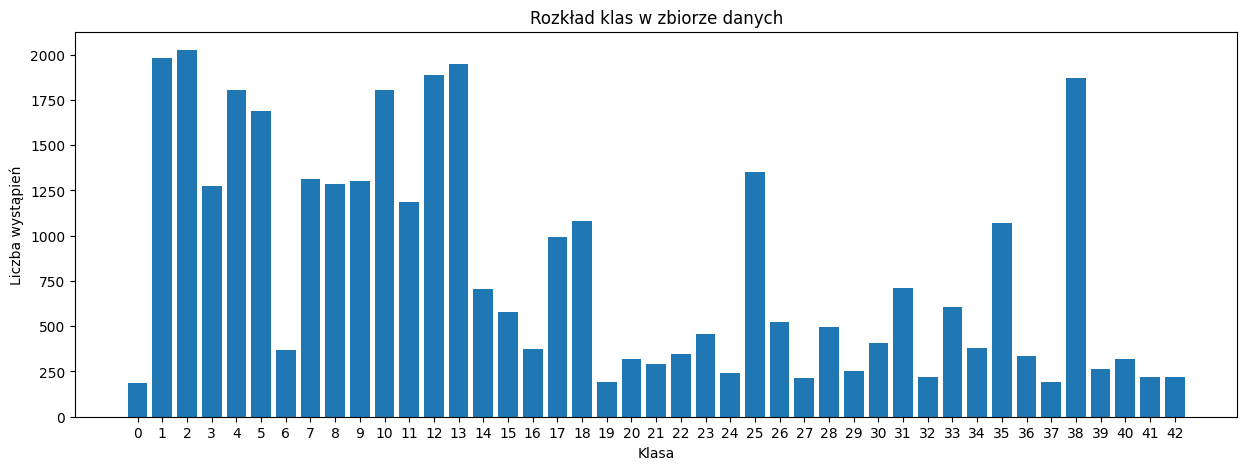

In [ ]:
# Liczba wystąpień klas
def count_classes(dataset):
    counts = {}
    for _, label in dataset:
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

# Wyświetlenie liczby wystąpień klas
def plot_class_distribution(dataset):
    plt.figure(figsize=(15, 5))
    counts = count_classes(dataset)
    classes = list(counts.keys())
    values = list(counts.values())

    plt.bar(classes, values)
    plt.xlabel("Klasa")
    plt.ylabel("Liczba wystąpień")
    plt.title("Rozkład klas w zbiorze danych")
    plt.xticks(classes)
    plt.show()

print("Liczba klas:", len(dataset.classes))
print("Liczba obrazów w zbiorze treningowym:", len(train_dataset))
print("Liczba obrazów w zbiorze testowym:", len(test_dataset))

plot_class_distribution(train_dataset)

Input shape: torch.Size([8, 3, 32, 32])


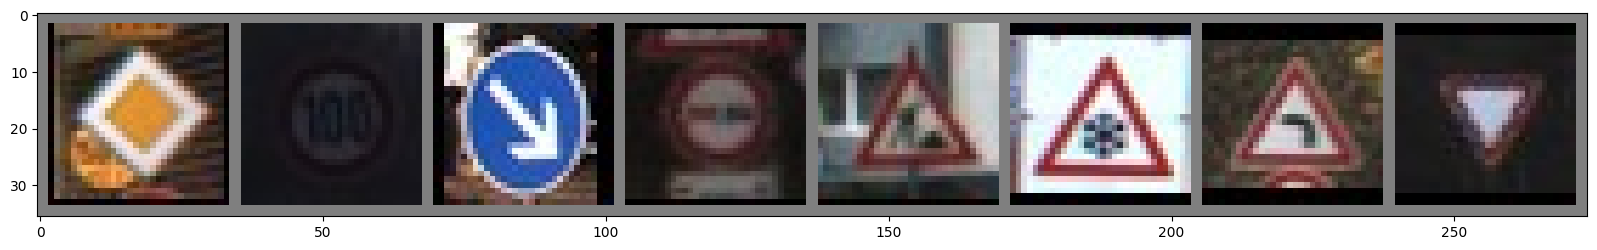

In [257]:
x, y = next(iter(train_loader))
x = x[:8]
print('Input shape:', x.shape)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

plt.figure(figsize = (20,10))
imshow(torchvision.utils.make_grid(x))


## Model dyfuzyjny

In [256]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount

In [259]:
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, use_conv_shortcut=False):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        self.block1 = nn.Sequential(
            nn.GroupNorm(1, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(1, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        h += self.time_mlp(t)[:, :, None, None]
        h = self.block2(h)
        return h + self.res_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()
        time_emb_dim = base_channels * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Down
        self.conv0 = ResidualBlock(in_channels, base_channels, time_emb_dim)
        self.down1 = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)
        self.down2 = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim)
        self.down3 = ResidualBlock(base_channels * 4, base_channels * 8, time_emb_dim)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bot = ResidualBlock(base_channels * 8, base_channels * 8, time_emb_dim)

        # Up
        self.up3 = ResidualBlock(base_channels * 16, base_channels * 4, time_emb_dim)
        self.up2 = ResidualBlock(base_channels * 8, base_channels * 2, time_emb_dim)
        self.up1 = ResidualBlock(base_channels * 4, base_channels, time_emb_dim)
        self.up0 = ResidualBlock(base_channels * 2, base_channels, time_emb_dim)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.final_conv = nn.Sequential(
            nn.GroupNorm(1, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, 1)
        )

    def forward(self, x, t):
        t = self.time_mlp(t)

        x0 = self.conv0(x, t)
        x1 = self.down1(self.pool(x0), t)
        x2 = self.down2(self.pool(x1), t)
        x3 = self.down3(self.pool(x2), t)

        x_bot = self.bot(self.pool(x3), t)

        u3 = self.up3(torch.cat([self.upsample(x_bot), x3], dim=1), t)
        u2 = self.up2(torch.cat([self.upsample(u3), x2], dim=1), t)
        u1 = self.up1(torch.cat([self.upsample(u2), x1], dim=1), t)
        u0 = self.up0(torch.cat([self.upsample(u1), x0], dim=1), t)

        return self.final_conv(u0)

In [260]:
net = UNet().to(device)
net

UNet(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): SiLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv0): ResidualBlock(
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=64, bias=True)
    )
    (block1): Sequential(
      (0): GroupNorm(1, 3, eps=1e-05, affine=True)
      (1): SiLU()
      (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (block2): Sequential(
      (0): GroupNorm(1, 64, eps=1e-05, affine=True)
      (1): SiLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (res_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): ResidualBlock(
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (block1): Sequential(
      (0): GroupNorm(1, 64, eps=1e-05, affine=True)
      (1): 

In [261]:
sum([p.numel() for p in net.parameters()])

14515657

In [262]:
loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

Finished epoch 0. Average loss for this epoch: 0.078045
Finished epoch 1. Average loss for this epoch: 0.042189
Finished epoch 2. Average loss for this epoch: 0.039374
Finished epoch 3. Average loss for this epoch: 0.036198
Finished epoch 4. Average loss for this epoch: 0.033324
Finished epoch 5. Average loss for this epoch: 0.030837
Finished epoch 6. Average loss for this epoch: 0.029036
Finished epoch 7. Average loss for this epoch: 0.028099
Finished epoch 8. Average loss for this epoch: 0.026194
Finished epoch 9. Average loss for this epoch: 0.025853
Finished epoch 10. Average loss for this epoch: 0.024626
Finished epoch 11. Average loss for this epoch: 0.024803
Finished epoch 12. Average loss for this epoch: 0.024504
Finished epoch 13. Average loss for this epoch: 0.024201
Finished epoch 14. Average loss for this epoch: 0.022943
Finished epoch 15. Average loss for this epoch: 0.022586
Finished epoch 16. Average loss for this epoch: 0.024443
Finished epoch 17. Average loss for this 

(0.0, 0.1)

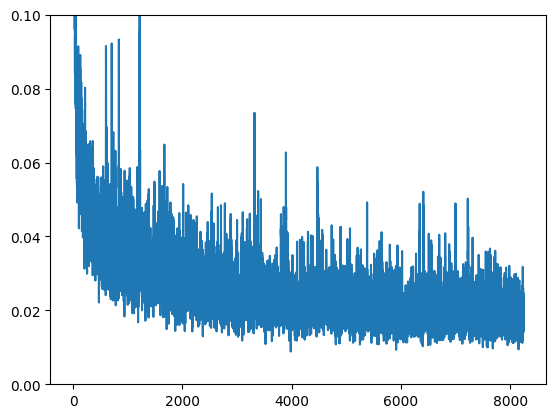

In [263]:
n_epochs = 30
losses = []

for epoch in range(n_epochs):
    for x, y in train_loader:
        x = x.to(device)

        # Losowanie ilości dodanego szumu - może być krok, albo jak w tym przypadku ciągła wartość w %
        noise_amount = torch.rand(x.shape[0]).to(device) 
        noisy_x = corrupt(x, noise_amount) 

        # Predykcja oryginalnego - czystego obrazka
        pred = net(noisy_x, noise_amount)

        # Porównanie z oryginalnym obrazkiem
        loss = loss_fn(pred, x)
 
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

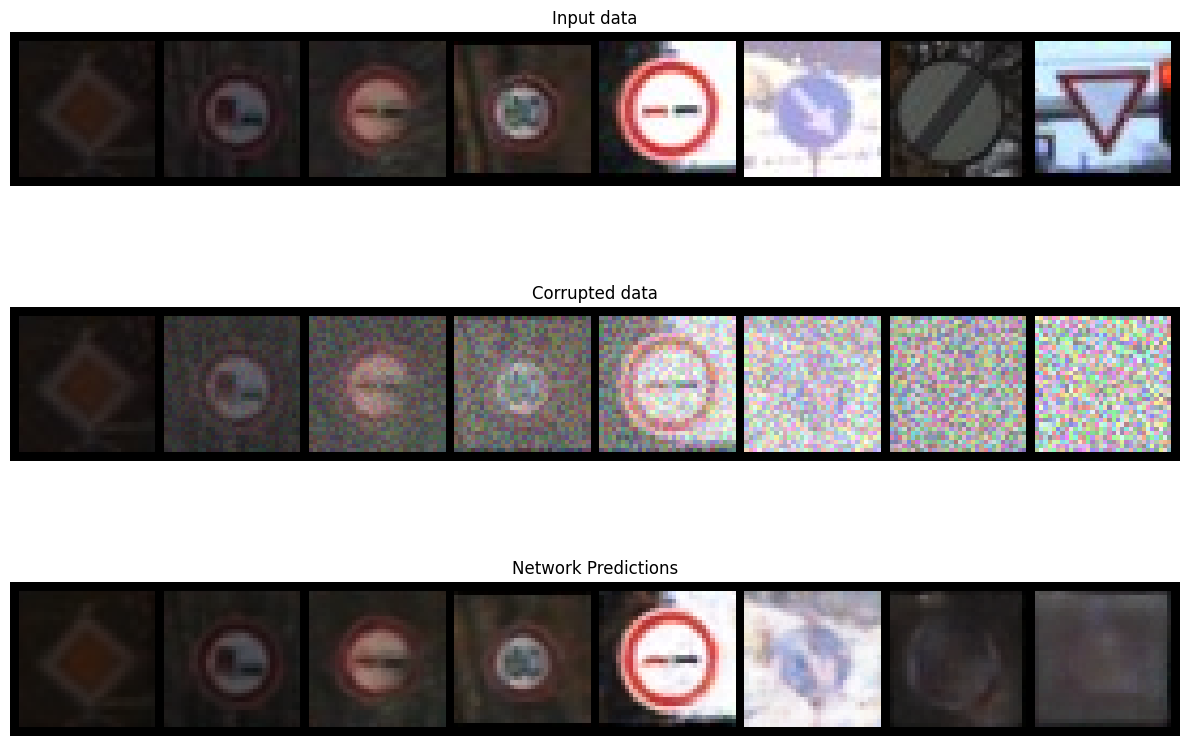

In [287]:
x, y = next(iter(train_loader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]).to(x.device)
amount_reshaped = amount[:, None, None, None]
noised_x = corrupt(x, amount_reshaped)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device), amount.to(device)).detach().cpu()

x = x / 2 + 0.5  # unnormalize
noised_x = noised_x / 2 + 0.5  # unnormalize
preds = preds / 2 + 0.5  # unnormalize

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 9))

# Helper function to handle RGB plotting
def show_rgb(tensor):
    grid = torchvision.utils.make_grid(tensor, nrow=8).permute(1, 2, 0).clip(0, 1)
    return grid

axs[0].set_title('Input data')
axs[0].imshow(show_rgb(x))
axs[0].axis('off')

axs[1].set_title('Corrupted data')
axs[1].imshow(show_rgb(noised_x))
axs[1].axis('off')

axs[2].set_title('Network Predictions')
axs[2].imshow(show_rgb(preds))
axs[2].axis('off')

plt.tight_layout()
plt.show()

(-0.5, 273.5, 273.5, -0.5)

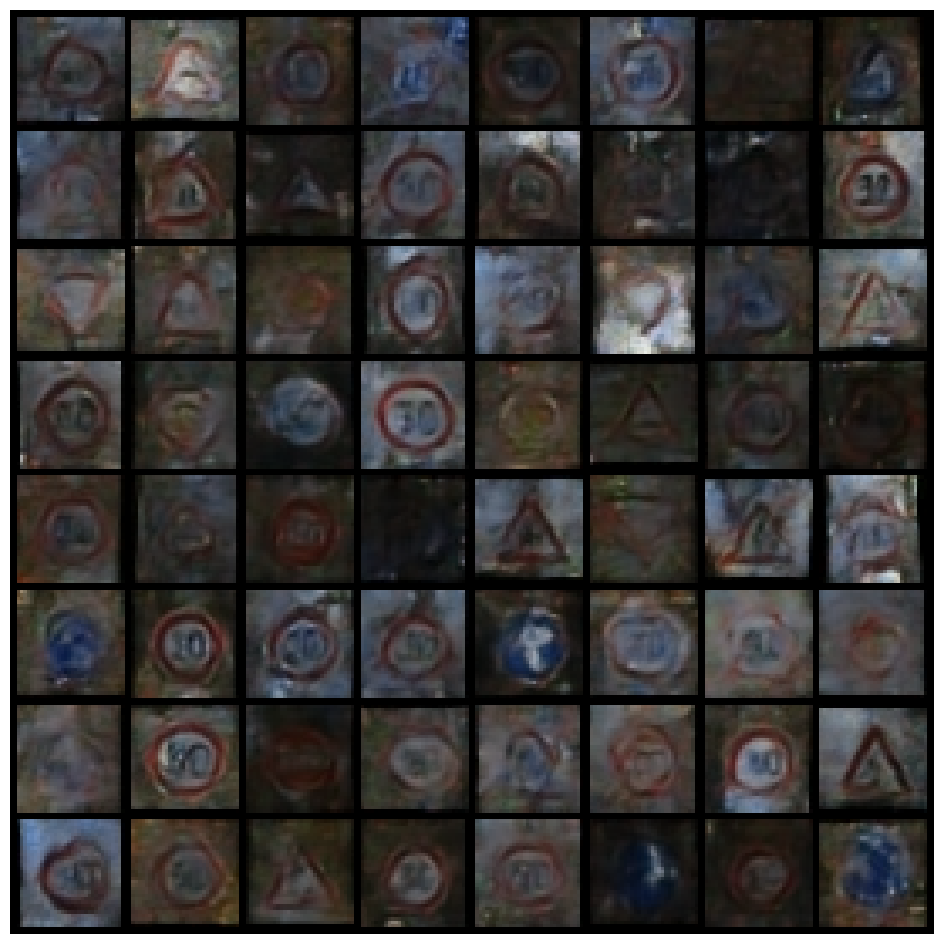

In [291]:
n_steps = 10
x = torch.rand(64, 3, 32, 32).to(device)

for i in range(n_steps):
  t = (torch.zeros(x.size(0)) + (n_steps - i)/n_steps).to(device)
  with torch.no_grad():
    pred = net(x, t)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

x = x / 2 + 0.5  # unnormalize

grid = torchvision.utils.make_grid(x.detach().cpu(), nrow=8)
ax.imshow(grid.permute(1, 2, 0).clip(0, 1))
ax.axis('off')

## Ocena jakości modelu

Mała sieć konwolucyjna

In [313]:
class Evaluator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2) # 32x32
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x16
        self.conv2 = nn.Conv2d(32, 32, 5) # 12x12
        self.bn_conv2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 6x6

        self.fc1 = nn.Linear(32 * 6 * 6, 128)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn_conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.fc3(x)
        
        return x

In [314]:
evaluator = Evaluator().to(device)
evaluator

Evaluator(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_conv1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn_conv2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=50, bias=True)
)

In [315]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)

In [318]:
max_num_epochs = 5

validation_losses = []
validation_accuracies = []
train_losses = []

for epoch in range(max_num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = evaluator(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    running_loss /= len(train_loader)
    print(f"[%d/{max_num_epochs}] Train loss: %.3f" % (epoch + 1, running_loss))
    train_losses.append(running_loss)

    # Validation - calculate loss
    validation_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = evaluator(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)
    validation_loss /= len(test_loader)
    validation_losses.append(validation_loss)

    print(f"Validation loss: {validation_loss:.3f}")
    print(f"Validation accuracy: {validation_accuracy:.2f}%")

print("Finished Training")

[1/5] Train loss: 0.022
Validation loss: 0.024
Validation accuracy: 99.49%
[2/5] Train loss: 0.010
Validation loss: 0.012
Validation accuracy: 99.74%
[3/5] Train loss: 0.009
Validation loss: 0.023
Validation accuracy: 99.49%
[4/5] Train loss: 0.023
Validation loss: 0.034
Validation accuracy: 99.13%
[5/5] Train loss: 0.019
Validation loss: 0.027
Validation accuracy: 99.29%
Finished Training


In [ ]:
n_steps = 15
x = torch.rand(1000, 3, 32, 32).to(device)

with torch.no_grad():
    for i in range(n_steps):
      t = (torch.zeros(x.size(0)) + (n_steps - i)/n_steps).to(device)
      with torch.no_grad():
        pred = net(x, t)
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor
        
generations_diffusion = x

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.62 GiB. GPU 0 has a total capacity of 3.81 GiB of which 1.28 GiB is free. Including non-PyTorch memory, this process has 2.52 GiB memory in use. Of the allocated memory 1.70 GiB is allocated by PyTorch, and 761.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)